In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from sklearn.preprocessing import normalize
warnings.filterwarnings('ignore')

In [2]:
'''
from google.colab import drive
drive.mount('/content/drive')
'''

"\nfrom google.colab import drive\ndrive.mount('/content/drive')\n"

In [3]:
# Read baseline qrels file
baseline_qrels_df = pd.read_csv("Part-1/fira-22.baseline-qrels.tsv", sep="\t", encoding='latin-1')

# Read documents file
documents_df = pd.read_csv("Part-1/fira-22.documents.tsv", sep="\t", encoding='latin-1')

# Read judgements file
judgements_df = pd.read_csv("Part-1/fira-22.judgements-anonymized.tsv", sep="\t",encoding='latin-1')

# Read queries file
queries_df = pd.read_csv("Part-1/fira-22.queries.tsv", sep="\t",encoding='latin-1')

In [4]:
#queries_df
judgements_df #4175 for queryID
#documents_df
#baseline_qrels_df

,id,relevanceLevel,relevanceCharacterRanges,durationUsedToJudgeMs,judgedAtUnixTS,documentId,queryId,userId
0,1,2_GOOD_ANSWER,<no ranges selected>,15712,1648481149,rob_FBIS3-10909,rob_q_FBIS3-10909,User_0
1,2,0_NOT_RELEVANT,<no ranges selected>,160000,1648481336,rob_FBIS3-10383,rob_q_FT941-8917,User_0
2,3,1_TOPIC_RELEVANT_DOES_NOT_ANSWER,<no ranges selected>,16699,1648481352,rob_FBIS3-10722,rob_q_FBIS3-32394,User_0
3,4,2_GOOD_ANSWER,<no ranges selected>,3442,1648481339,rob_FBIS3-11360,rob_q_FBIS3-11360,User_1
4,5,2_GOOD_ANSWER,<no ranges selected>,15849,1648481354,rob_FBIS3-11056,rob_q_FBIS3-11617,User_1
...,...,...,...,...,...,...,...,...
67219,67676,3_PERFECT_ANSWER,133-399;1863-2100,54516,1649724672,trip_1766631,trip_228289,User_49
67220,67677,3_PERFECT_ANSWER,116-272;1694-1846,35868,1649724708,trip_1768761,trip_22420,User_49
67221,67678,3_PERFECT_ANSWER,123-278;1809-2013,58469,1649724767,trip_1771729,trip_27540,User_49
67222,67679,3_PERFECT_ANSWER,110-401,65513,1649724832,trip_1772193,trip_31051,User_49


**Part 1 (Calculate the median of the judgements) -> Median is a robust way to outliers**

In [5]:
# Keepp only the columns relevanceLevel, documentId and queryId
judgements = judgements_df[['relevanceLevel', 'documentId', 'queryId']]

# Remove NAs based on the relevanceLevel column
judgements.dropna(subset=['relevanceLevel'], inplace=True)

# Do a mapping to replace the values of the column relevancelevel to values from 0-3
mapping = {
    '0_NOT_RELEVANT': 0,
    '1_TOPIC_RELEVANT_DOES_NOT_ANSWER': 1,
    '2_GOOD_ANSWER': 2,
    '3_PERFECT_ANSWER': 3
}
judgements['relevanceLevel'] =judgements['relevanceLevel'].map(mapping)

# Group by 'queryID' and 'documentID', then calculate the median of 'relevance_level'
median_judgements = judgements.groupby(['documentId', 'queryId'])['relevanceLevel'].median().reset_index()

median_judgements

,documentId,queryId,relevanceLevel
0,db_<dbpedia:...That's_the_Way_It_Is>,db_q_<dbpedia:...That's_the_Way_It_Is>,3.0
1,db_<dbpedia:.hn>,db_q_<dbpedia:.hn>,2.0
2,db_<dbpedia:1041>,db_q_<dbpedia:House_at_1141_North_Chester_Avenue>,0.0
3,db_<dbpedia:10th_FAI_World_Rally_Flying_Champi...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,3.0
4,db_<dbpedia:14th_FAI_World_Rally_Flying_Champi...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,2.0
...,...,...,...
24184,trip_9995113,trip_21570,2.0
24185,trip_9996063,trip_69729,2.0
24186,trip_9996897,trip_59524,2.0
24187,trip_9997726,trip_675583,1.0


**Part 2 (Text Similarity)**

In [4]:
# Find the unique document and query IDs that are used in the judgements dataset
# We do that in order then to calculate the embeddings for the specific documents and queries and not for all of them
unique_queries = median_judgements.queryId.unique().tolist()
unique_documents = median_judgements.documentId.unique().tolist()
print(len(unique_queries))
print(len(unique_documents))

4175
21190


In [7]:
'''
This part of the preprocessing is skipped because the problem is solved using the encoding='latin-1' in pd.read_csv

# First we do some preprocessing on the queries data set
# 1. Create a copy
processed_queries_df = queries_df.copy()

# 2. Merge the two columns that have been created due to a problem when read the .tsv file
processed_queries_df['query_text'] = queries_df['query_id'].astype(str).fillna('') + queries_df['query_text'].fillna('')

# 3. Drop the query id column
processed_queries_df.drop(columns=['query_id'], inplace=True)

# 4. Reset the index because when the .tsv file was read, the query id went to the index and not to a seperate column
processed_queries_df.reset_index(inplace=True)

# 5. Rename the index column, after the reset, to query_id
processed_queries_df = processed_queries_df.rename(columns={'index': 'query_id'})

# Print the queries data set before the preprocessing
print(queries_df.head(5))

# Print the queries data set after the preprocessing
print(processed_queries_df.head(5))
'''

"\n\nThis part of the preprocessing is skipped because the problem is solved using the encoding='latin-1' in pd.read_csv\n\n# First we do some preprocessing on the queries data set\n# 1. Create a copy\nprocessed_queries_df = queries_df.copy()\n\n# 2. Merge the two columns that have been created due to a problem when read the .tsv file\nprocessed_queries_df['query_text'] = queries_df['query_id'].astype(str).fillna('') + queries_df['query_text'].fillna('')\n\n# 3. Drop the query id column\nprocessed_queries_df.drop(columns=['query_id'], inplace=True)\n\n# 4. Reset the index because when the .tsv file was read, the query id went to the index and not to a seperate column\nprocessed_queries_df.reset_index(inplace=True)\n\n# 5. Rename the index column, after the reset, to query_id\nprocessed_queries_df = processed_queries_df.rename(columns={'index': 'query_id'})\n\n# Print the queries data set before the preprocessing\nprint(queries_df.head(5))\n\n# Print the queries data set after the prepr

In [5]:
# From the query data set take the queries based on the unique IDs calculated in the previous step
filted_queries = queries_df[queries_df['query_id'].isin(unique_queries)].reset_index(drop=True)
filted_queries

,query_id,query_text
0,trip_24,pain management nursing
1,trip_40,food intolerance
2,trip_55,green tea
3,trip_59,paediatric intensive care
4,trip_67,diarrhea children
...,...,...
4170,rob_qq_FBIS4-15279,Who are the two diplomatic correspondents of ...
4171,rob_qq_LA051090-0014,What was the profit a year earlier?
4172,rob_qq_FT911-4533,How many non-rail workers could be temporaril...
4173,rob_qq_LA070289-0170,What is the new government dedicated to prose...


In [6]:
# The same is done for the documents
filted_documents = documents_df[documents_df['doc_id'].isin(unique_documents)].reset_index(drop=True)
filted_documents

,doc_id,doc_text
0,trip_284113,effect of youth - onset type 2 diabetes mellit...
1,trip_284137,prophylaxis strategies for contrast - induced ...
2,trip_284217,"mental health problems , use of mental health ..."
3,trip_284589,mixed dementia : emerging concepts and therape...
4,trip_284727,mmr vaccination and febrile seizures : evaluat...
...,...,...
21185,rob_LA122890-0027,""""""" sports ; part c ; page 5 ; column 1 ; spor..."
21186,rob_LA122989-0131,""""""" calendar ; part f ; page 2 ; column 1 ; en..."
21187,rob_LA123089-0069,view ; part f ; page 24 ; column 1 ; view desk...
21188,rob_LA123189-0053,""""""" calendar ; page 8 ; calendar desk diving i..."


In [8]:
# Install the transformer
!pip install -U sentence-transformers

Looking in indexes: https://repo.eb.lan.at/artifactory/api/pypi/pypi-repo/simple
  Using cached https://repo.eb.lan.at/artifactory/api/pypi/pypi-repo/packages/packages/76/2c/bd95032aeb087b0706596af0a4518c4bfe0439a1bb149048ece18b617766/sentence_transformers-2.7.0-py3-none-any.whl (171 kB)
  Using cached https://repo.eb.lan.at/artifactory/api/pypi/pypi-repo/packages/packages/07/78/c23e1c70b89f361d855a5d0a19b229297f6456961f9a1afa9a69cd5a70c3/transformers-4.41.0-py3-none-any.whl (9.1 MB)
     ---------------------------------------- 0.0/401.3 kB ? eta -:--:--
     -------------------------------- ---- 348.2/401.3 kB 10.6 MB/s eta 0:00:01
     -------------------------------------  399.4/401.3 kB 8.3 MB/s eta 0:00:01
     -------------------------------------- 401.3/401.3 kB 3.6 MB/s eta 0:00:00
  Using cached https://repo.eb.lan.at/artifactory/api/pypi/pypi-repo/packages/packages/ba/a3/16e9fe32187e9c8bc7f9b7bcd9728529faa725231a0c96f2f98714ff2fc5/fsspec-2024.5.0-py3-none-any.whl (316 kB)
  

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
s3fs 2023.3.0 requires fsspec==2023.3.0, but you have fsspec 2024.5.0 which is incompatible.


In [10]:
# Documention
# https://www.sbert.net/
# https://arxiv.org/abs/1908.10084
from sentence_transformers import SentenceTransformer
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

def generate_embeddings(text):
    embedding = model.encode(text)
    return embedding

modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.73k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/314 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [11]:
%%time
# Apply sentence transformer for the queries
# Uncomment to generate the embeddings for the queries

filted_queries['bert_embeddings_queries'] = filted_queries['query_text'].apply(generate_embeddings)
filted_queries

CPU times: total: 3min 18s
Wall time: 1min 53s


,query_id,query_text,bert_embeddings_queries
0,trip_24,pain management nursing,"[-0.5180407, -0.16784486, 0.37757254, 0.431851..."
1,trip_40,food intolerance,"[0.0872229, -0.4347618, -0.36454573, 0.6571815..."
2,trip_55,green tea,"[-0.32914746, -0.1796494, 0.07237147, 0.851165..."
3,trip_59,paediatric intensive care,"[-0.23361944, -0.25168425, 0.07497846, 0.23268..."
4,trip_67,diarrhea children,"[0.2963357, -0.34332, -0.16621889, 0.06617608,..."
...,...,...,...
4170,rob_qq_FBIS4-15279,Who are the two diplomatic correspondents of ...,"[-0.27384183, -0.19835898, -0.45374852, -0.131..."
4171,rob_qq_LA051090-0014,What was the profit a year earlier?,"[-0.27626052, 0.47689024, 0.14732333, -0.06921..."
4172,rob_qq_FT911-4533,How many non-rail workers could be temporaril...,"[0.6177384, -0.2929287, 0.6608447, 0.472324, 0..."
4173,rob_qq_LA070289-0170,What is the new government dedicated to prose...,"[-0.27253726, 0.16098277, -0.3323587, -0.27405..."


In [12]:
%%time
# Apply sentence transformer for the documents
# Uncomment to generate the embeddings for the documents

filted_documents['bert_embeddings_documents'] = filted_documents['doc_text'].apply(generate_embeddings)
filted_documents

CPU times: total: 1h 33min 37s
Wall time: 28min 52s


,doc_id,doc_text,bert_embeddings_documents
0,trip_284113,effect of youth - onset type 2 diabetes mellit...,"[0.017911632, 0.5206385, 0.10963909, -0.091547..."
1,trip_284137,prophylaxis strategies for contrast - induced ...,"[-0.3518055, 0.17939025, 0.21992703, -0.138955..."
2,trip_284217,"mental health problems , use of mental health ...","[0.124521464, -0.005803716, 0.20561787, -0.193..."
3,trip_284589,mixed dementia : emerging concepts and therape...,"[-0.2054602, -0.049847037, 0.19414167, -0.2692..."
4,trip_284727,mmr vaccination and febrile seizures : evaluat...,"[0.1265985, 0.052221213, 0.24581037, -0.314605..."
...,...,...,...
21185,rob_LA122890-0027,""""""" sports ; part c ; page 5 ; column 1 ; spor...","[-0.14209634, -0.2088959, 0.14444916, 0.005986..."
21186,rob_LA122989-0131,""""""" calendar ; part f ; page 2 ; column 1 ; en...","[0.16619122, -0.41120803, -0.18878967, -0.0475..."
21187,rob_LA123089-0069,view ; part f ; page 24 ; column 1 ; view desk...,"[0.08724066, -0.17054954, 0.052711006, 0.19272..."
21188,rob_LA123189-0053,""""""" calendar ; page 8 ; calendar desk diving i...","[-0.1258979, 0.3444479, -0.051961444, 0.268951..."


In [13]:
# Save the embeddings into a csv file so that we dont have to create them again
# Check if the files already exist
queries_filename = "queries_with_embeddings.csv"
documents_filename = "documents_with_embeddings.csv"

# Check if the files already exist
if os.path.isfile(queries_filename) and os.path.isfile(documents_filename):
    print("CSV files already exist. Reading them...")
    filted_queries = pd.read_csv(queries_filename)
    filted_documents = pd.read_csv(documents_filename)
    temp_str_to_float = True
    print("CSV files read successfully.")
else:
    print("Saving new files...")
    filted_queries.to_csv(queries_filename, index=False)
    filted_documents.to_csv(documents_filename, index=False)
    temp_str_to_float = False
    print("New CSV files saved successfully.")


Saving new files...
New CSV files saved successfully.


In [14]:
# Now we have to merge the query/documents embeddings with the raw judgements from the users
final_judgements = pd.merge(median_judgements, filted_queries[['query_id','bert_embeddings_queries']], left_on='queryId', right_on='query_id', how='left').drop(['query_id'], axis=1)
final_judgements = pd.merge(final_judgements, filted_documents[['doc_id','bert_embeddings_documents']], left_on='documentId', right_on='doc_id', how='left').drop(['doc_id'], axis=1)
final_judgements.head()

,documentId,queryId,relevanceLevel,bert_embeddings_queries,bert_embeddings_documents
0,db_<dbpedia:...That's_the_Way_It_Is>,db_q_<dbpedia:...That's_the_Way_It_Is>,3.0,"[-0.19594409, -0.18845983, -0.14667097, 0.1968...","[0.012206504, -0.1915299, -0.021097649, -0.133..."
1,db_<dbpedia:.hn>,db_q_<dbpedia:.hn>,2.0,"[-0.34395, 0.0054212892, -0.893418, -0.5967298...","[-0.6586339, -0.07489771, -0.5930509, -0.25279..."
2,db_<dbpedia:1041>,db_q_<dbpedia:House_at_1141_North_Chester_Avenue>,0.0,"[-0.95408535, 0.5445484, 0.047150254, -0.15520...","[-0.5705301, 0.08617861, -0.0064082397, 0.1329..."
3,db_<dbpedia:10th_FAI_World_Rally_Flying_Champi...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,3.0,"[0.6618954, -0.045408443, -0.22051212, -0.3234...","[0.26452708, 0.1591166, -0.13649264, -0.322656..."
4,db_<dbpedia:14th_FAI_World_Rally_Flying_Champi...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,2.0,"[0.6618954, -0.045408443, -0.22051212, -0.3234...","[0.44385135, 0.23152936, -0.3328092, -0.365005..."


In [15]:
# Convert the embeddings from str to float array
def convert_tofloat_array(numbers_string):
    numbers_list = numbers_string.strip('[]').split()
    array_float = np.array([float(num) for num in numbers_list])
    return array_float

if temp_str_to_float:
    print("Converting the embeddings from str to float...")
    final_judgements['bert_embeddings_queries'] = final_judgements['bert_embeddings_queries'].apply(convert_tofloat_array)
    final_judgements['bert_embeddings_documents'] = final_judgements['bert_embeddings_documents'].apply(convert_tofloat_array)
    print("DONE")
    temp_str_to_float = False

In [16]:
# Calculate the cosine similarity
def calculation_cosine_similarity(query_text,document_text):
    
    query_text = query_text.reshape(1, -1)
    document_text = document_text.reshape(1, -1)
    
    cosine_sim_value = cosine_similarity(query_text,document_text)
    
    return cosine_sim_value[0][0]

# Finally we calculate the cosine similarity between the embeddings (queries and documents)
query = final_judgements['bert_embeddings_queries']
document = final_judgements['bert_embeddings_documents']

final_judgements['Cosine_Similarity'] = final_judgements.apply(lambda row: calculation_cosine_similarity(row.bert_embeddings_queries, row.bert_embeddings_documents), axis=1)

In [17]:
# Now we do the mapping for the cosine similarity
# 0 -> cosine_similarity < 0.2
# 1 -> 0.2 <= cosine_similarity < 0.5
# 2 -> 0.5 <= cosine_similarity < 0.7
# 3 -> 0.7 <= cosine_similarity <= 1
relevance_similarity = []
for sim in final_judgements['Cosine_Similarity']:
    if sim < 0.2:
        relevance_similarity.append(0)
    elif sim < 0.5:
        relevance_similarity.append(1)
    elif sim < 0.7:
        relevance_similarity.append(2) 
    else:
        relevance_similarity.append(3)

final_judgements['relevance_similarity'] = relevance_similarity
final_judgements['relevanceLevel'] = final_judgements['relevanceLevel'].astype(int)
final_judgements

# Ignore this 
# We filter our final_judgement data set by checking if relevanceLevel == relevance_similarity
# filtered_final_judgements = final_judgements[final_judgements['relevanceLevel'] == final_judgements['relevance_similarity']].reset_index(drop=True)
# filtered_final_judgements

,documentId,queryId,relevanceLevel,bert_embeddings_queries,bert_embeddings_documents,Cosine_Similarity,relevance_similarity
0,db_<dbpedia:...That's_the_Way_It_Is>,db_q_<dbpedia:...That's_the_Way_It_Is>,3,"[-0.19594409, -0.18845983, -0.14667097, 0.1968...","[0.012206504, -0.1915299, -0.021097649, -0.133...",0.656641,2
1,db_<dbpedia:.hn>,db_q_<dbpedia:.hn>,2,"[-0.34395, 0.0054212892, -0.893418, -0.5967298...","[-0.6586339, -0.07489771, -0.5930509, -0.25279...",0.622585,2
2,db_<dbpedia:1041>,db_q_<dbpedia:House_at_1141_North_Chester_Avenue>,0,"[-0.95408535, 0.5445484, 0.047150254, -0.15520...","[-0.5705301, 0.08617861, -0.0064082397, 0.1329...",0.500974,2
3,db_<dbpedia:10th_FAI_World_Rally_Flying_Champi...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,3,"[0.6618954, -0.045408443, -0.22051212, -0.3234...","[0.26452708, 0.1591166, -0.13649264, -0.322656...",0.497539,1
4,db_<dbpedia:14th_FAI_World_Rally_Flying_Champi...,db_q_<dbpedia:10th_FAI_World_Rally_Flying_Cham...,2,"[0.6618954, -0.045408443, -0.22051212, -0.3234...","[0.44385135, 0.23152936, -0.3328092, -0.365005...",0.538710,2
...,...,...,...,...,...,...,...
24184,trip_9995113,trip_21570,2,"[-0.4454425, 0.18348753, -0.63641274, -0.61625...","[-0.40636748, -0.17048594, 0.12433969, -0.2807...",0.539195,2
24185,trip_9996063,trip_69729,2,"[0.18126245, -0.4127771, -0.05945651, -0.13345...","[-0.064951286, -0.018399354, -0.10201276, -0.0...",0.463312,1
24186,trip_9996897,trip_59524,2,"[0.14589891, -0.04910648, 0.23032491, 0.007741...","[0.19707713, 0.032435592, -0.20889124, -0.3252...",0.701981,3
24187,trip_9997726,trip_675583,1,"[-0.2283021, 0.011149959, -0.25403136, -0.3325...","[0.045154966, 0.23880142, -0.13228545, -0.1399...",0.560286,2


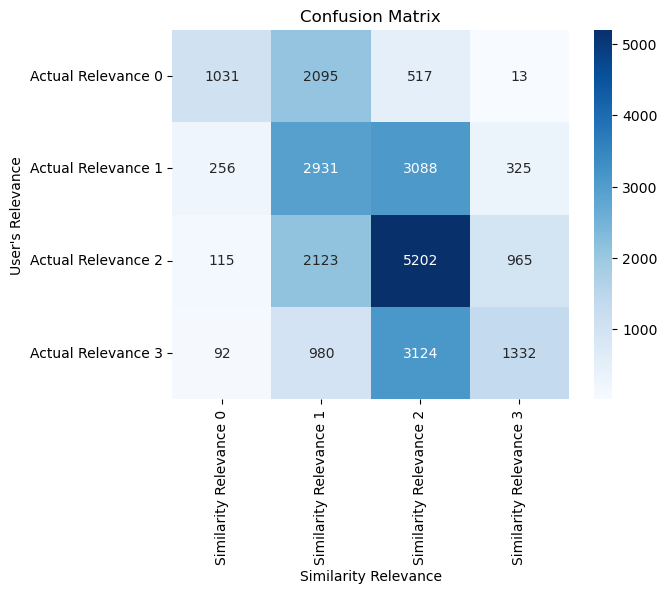

              precision    recall  f1-score   support

           0       0.69      0.28      0.40      3656
           1       0.36      0.44      0.40      6600
           2       0.44      0.62      0.51      8405
           3       0.51      0.24      0.33      5528

    accuracy                           0.43     24189
   macro avg       0.50      0.40      0.41     24189
weighted avg       0.47      0.43      0.42     24189



In [18]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Here, a confusion matrix along with additional metrics are created

cm  = confusion_matrix(final_judgements['relevanceLevel'], final_judgements['relevance_similarity'])

cm_df = pd.DataFrame(cm, index=['Actual Relevance 0', 'Actual Relevance 1','Actual Relevance 2','Actual Relevance 3'],
                     columns=['Similarity Relevance 0', 'Similarity Relevance 1', 'Similarity Relevance 2', 'Similarity Relevance 3'])

sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.xlabel('Similarity Relevance')
plt.ylabel('User\'s Relevance')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(final_judgements['relevanceLevel'], final_judgements['relevance_similarity']))

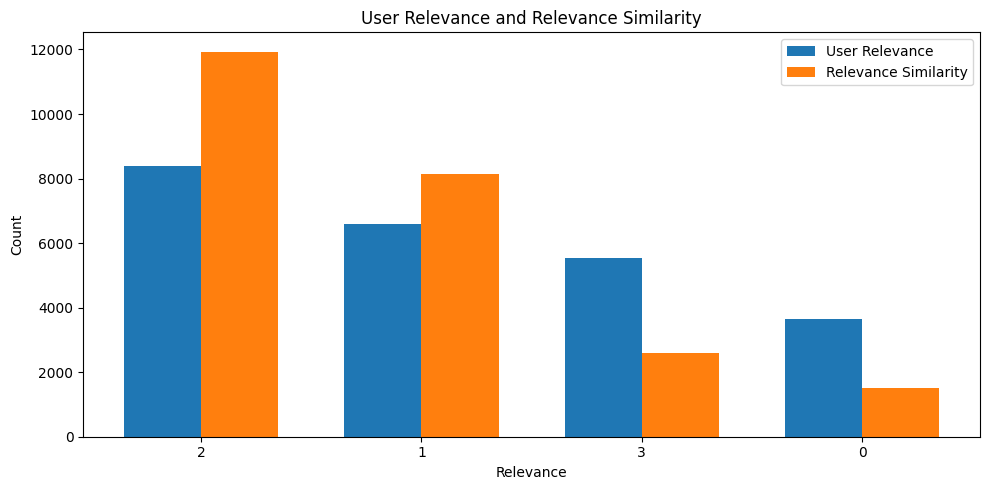

In [46]:
# TODO a barlot for the Users' relevance vs the similarity relevance
plt.figure(figsize=(10, 5))

# Get unique categories
categories = final_judgements['relevanceLevel'].value_counts().index

# Calculate the width for each bar
bar_width = 0.35

# Set the positions for the bars
index = np.arange(len(categories))

# Plotting the first set of bars
plt.bar(index, final_judgements['relevanceLevel'].value_counts(), bar_width, label='User Relevance')

# Plotting the second set of bars, shift the positions
plt.bar(index + bar_width, final_judgements['relevance_similarity'].value_counts(), bar_width, label='Relevance Similarity')

# Adding labels and title
plt.title('User Relevance and Relevance Similarity')
plt.xlabel('Relevance')
plt.ylabel('Count')
plt.xticks(index + bar_width / 2, categories)
plt.legend()

plt.tight_layout()
plt.show()

In [19]:
# Final creation of the data set that is going to be used in the second exercise
# The format of this data set will be similar to the baseline, provided by the instructions of the exercise
# Example 1: rob_q_FBIS3-10909 Q0 rob_FBIS3-10909 2
# Example 2: rob_q_FT941-8917 Q0 rob_FBIS3-10383 1
# Etc... 
def format_row(row):
    return f"{row['queryId']} Q0 {row['documentId']} {int(row['relevanceLevel'])}"
    
final_df_exercise_1 = median_judgements.apply(format_row, axis=1)

In [20]:
print("Saving the final data frame for the 1st exercise as a .tsv file...")
filename = "Final_Exercise_1.tsv"
final_df_exercise_1.to_csv(filename, sep='\t', index=False, header=False)
print("New TSV file saved successfully.")

Saving the final data frame for the 1st exercise as a .tsv file...
New TSV file saved successfully.
